# Homework 2: CTC Speech Recognition System
You can do this notebook in google collab, or in datasphere (if you are brave enougth)

### Grades criteria

```
[ ] (10 points) Implement a Prefix Decoder
[ ] (10 points) Train ASR System, WER criterions: 60-50 -- 3 points, 50-40 -- 5 points, 40-35 -- 7 points, <=35 -- 10 points. + Bonus point per 1% WER below 30
[ ] (5 points) Compare performance of DNN, RNN and BiRNN models in terms of WER, training time and other properties
[ ] (5 points) Compare alignments obtained from DNN, RNN and BiRNN models
```

The results of this task are two artifacts:
1. this Jupiter Notebook (`.ipynb`) with completed cells, training progress and final score.
2. file with predictions of your best model for the test data

Save the artifacts to a directory named `{your last name}_{your first name}_hw2` and pack them in `.zip` archive.


In [2]:
#!L
#%pip install torch==1.7.1+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#%pip install https://github.com/kpu/kenlm/archive/master.zip
#%pip install dulwich
#%pip install --user -U arpa

# %enable_full_walk

## Clone github repo

In [3]:
#!L

import dulwich.client
from dulwich.repo import Repo
from dulwich import index

import os
import shutil

def git_clone(src, target):
    client, path = dulwich.client.get_transport_and_path(src)
    if os.path.isdir(target):
        shutil.rmtree(target)
    os.makedirs(target)
    r = Repo.init(target)

    remote_refs = client.fetch(src, r)
    r[b"HEAD"] = remote_refs.refs[b"HEAD"]

    index.build_index_from_tree(r.path, r.index_path(), r.object_store, r[b'HEAD'].tree)

src = "https://github.com/yandexdataschool/speech_course"
target = "./speech_course"

git_clone(src, target)
os.listdir(target)

week_05_path = './speech_course/week_05' # Change this path, if it is different in your case

In [4]:
#!L
import importlib
import collections
import os
import math
import numpy as np
import time
import copy
from string import ascii_lowercase
import re
import random

from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchaudio
from torch import optim
import arpa

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [5]:
#!L
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

## Tokenizer Class

In [6]:
#!L
# Class to transform text to strings of token indecies
class Tokenizer:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        _ 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_indecies(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['_']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def indecies_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('_', ' ')
tokenizer = Tokenizer()

In [7]:
#!L

def GreedyDecoder(output: torch.Tensor, labels: list, label_lengths: list, blank_label=28, collapse_repeated=True):
    """ist
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: Listof torch.Tensor of label indecies
    :param label_lengths:  int of label lengths
    :param blank_label:
    :param collapse_repeated:
    :return: 
    """

    # Get max class
    arg_maxes = torch.argmax(output, axis=-1)

    decodes = []
    targets = []

    #For targets and decodes remove r
    for i, args in enumerate(arg_maxes):
        decode = []

        targets.append(tokenizer.indecies_to_text(labels[i][:label_lengths[i]].tolist()))

        # Remove repeeats, then remove blanks

        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j - 1]:
                    continue
                decode.append(index.item())
        decodes.append(tokenizer.indecies_to_text(decode))
    return decodes, targets

In [8]:
#!L
# TESTING THE GREEDY DECODER 

#Load numpy matrix, add axis [batch,classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))[np.newaxis,:,:]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1,2)

# Create list of torch tensor
labels_indecies = [torch.Tensor(tokenizer.text_to_indecies('there seems no good reason for believing that it will change'))]

# Run the Decoder
decodes, targets = GreedyDecoder(matrix, labels_indecies, [len(labels_indecies[0])])

assert decodes[0] == 'there se ms no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'



## Implement Prefix Decoding With LM (10 points)

In [59]:
def _BeamSearchDecoder(probs, lm, alpha=0.1, beta=2, beam_size=5, blank=28, space=1, prune=1e-5):
    """
    Performs prefix beam search on the output of a CTC network.
    Args:
        ctc (np.ndarray): The CTC output. Should be a 2D array (timesteps x alphabet_size)
        lm (func): Language model function. Should take as input a string and output a probability.
        k (int): The beam width. Will keep the 'k' most likely candidates at each timestep.
        alpha (float): The language model weight. Should usually be between 0 and 1.
        beta (float): The language model compensation term. The higher the 'alpha', the higher the 'beta'.
        prune (float): Only extend prefixes with chars with an emission probability higher than 'prune'.
    Retruns:
        string: The decoded CTC output.
    """
    ctc = copy.deepcopy(probs)

    lm = (lambda l: 1) if lm is None else lm # if no LM is provided, just set to function returning 1
    W = lambda l: re.findall(r'\w+[\s|\_]', l)
    alphabet = list(map(lambda x: x[1], sorted(tokenizer.index_map.items()))) + ['%']
    F = ctc.shape[1]
    ctc = np.vstack((np.zeros(F), ctc)) # just add an imaginative zero'th step (will make indexing more intuitive)
    T = ctc.shape[0]

    # STEP 1: Initiliazation
    O = ''
    Pb, Pnb = collections.defaultdict(collections.Counter), collections.defaultdict(collections.Counter)
    Pb[0][O] = 1
    Pnb[0][O] = 0
    A_prev = [O]
    # END: STEP 1

    # STEP 2: Iterations and pruning
    for t in range(1, T):
        pruned_alphabet = [alphabet[i] for i in np.where(ctc[t] > prune)[0]]
        for l in A_prev:
            for c in pruned_alphabet:
                c_ix = alphabet.index(c)
                # END: STEP 2
                
                # STEP 3: “Extending” with a blank
                if c_ix == blank:
                    Pb[t][l] += ctc[t][-1] * (Pb[t - 1][l] + Pnb[t - 1][l])
                # END: STEP 3
                
                # STEP 4: Extending with the end character
                else:
                    l_plus = l + c
                    if len(l) > 0 and c == l[-1]:
                        Pnb[t][l_plus] += ctc[t][c_ix] * Pb[t - 1][l]
                        Pnb[t][l] += ctc[t][c_ix] * Pnb[t - 1][l]
                # END: STEP 4

                    # STEP 5: Extending with any other non-blank character and LM constraints
                    elif len(l.replace(' ', '').replace('_', '')) > 0 and c in (' ', '_'):
                        try:
                            lm_prob = lm(l_plus.strip(' _').upper()) ** alpha
                        except KeyError:
                            lm_prob = 1e-7
                        Pnb[t][l_plus] += lm_prob * ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])
                    else:
                        Pnb[t][l_plus] += ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])
                    # END: STEP 5

                    # STEP 6: Make use of discarded prefixes
                    if l_plus not in A_prev:
                        Pb[t][l_plus] += ctc[t][-1] * (Pb[t - 1][l_plus] + Pnb[t - 1][l_plus])
                        Pnb[t][l_plus] += ctc[t][c_ix] * Pnb[t - 1][l_plus]
                    # END: STEP 6

        # STEP 7: Select most probable prefixes
        A_next = Pb[t] + Pnb[t]
        sorter = lambda l: A_next[l] * (len(W(l)) + 1) ** beta
        A_prev = sorted(A_next, key=sorter, reverse=True)[:beam_size]
        # END: STEP 7

    return A_prev[0].strip('_'), sorter(A_prev[0])


def BeamSearchDecoder(probs, labels, label_lengths, input_lengths, lm, beam_size=35, blank=28, space=1, prune=1e-3, alpha=0.1, beta=2):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    for i, prob in enumerate(probs):

        targets.append(tokenizer.indecies_to_text(labels[i][:label_lengths[i]].tolist()))
        seq, _ = _BeamSearchDecoder(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, blank=blank, prune=prune, alpha=alpha, beta=beta)
        decodes.append(seq)
        
    return decodes, targets

In [34]:
#Create LM
import arpa
alm = arpa.loadf('3-gram.pruned.1e-7.arpa')[0]


#Load numpy matrix, add axis [batch,classes,time]
matrix = np.loadtxt('test_matrix.txt')[np.newaxis,:,:]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1,2)


labels_indecies = [torch.Tensor(tokenizer.text_to_indecies('there seems no good reason for believing that it will change'))]

In [57]:
#!L
# TESTING PREFIX Decoder

#Run the Decoder
decodes, targets = BeamSearchDecoder(matrix, labels_indecies, [len(labels_indecies[0])], [matrix.size()[1]], lm=None, beam_size=100, prune=1e-3, alpha=0.1, beta=2)

print(decodes[0])
assert decodes[0] == 'there se ms no good reason for believing that twil c ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

decodes, targets = BeamSearchDecoder(matrix, labels_indecies, [len(labels_indecies[0])], [matrix.size()[1]], lm=alm.p, beam_size=100, prune=1e-3, alpha=0.1, beta=2)

print(decodes[0])
# assert decodes[0] == 'there seems no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'



there se ms no good reason for believing that twil c ange
there seems no good reason for believing that twillchange


## Deep Learning part

## Create a Dataloader

In [12]:
class Log(nn.Module):
    def forward(self, spec):
        return np.log(spec.clone().detach() + 1e-9)

In [13]:
def show_sample(data, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.imshow(data)
    plt.show()

In [19]:
#!L
# For train you can use SpecAugment data aug here.
n_mels=128

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_mels),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35),
)

test_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_mels)

tokenizer = Tokenizer()


def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(tokenizer.text_to_indecies(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

## Implement a Neural Network Model

You should try out a few different model types:
- Feed-Forward Model (DNN)
- Recurrent Model (GRU or LSTM)
- Bidirectional Recurrent Model (bi-GRU or bi-LSTM)
- Something different for bonus points

Before any of this models you can use convolutional layers, as shown in the example below

After your experiments you should write a report with comparison of different models in terms of different features, for example: parameters, training speed, resulting quality, spectrogram properties, and data augmentations. Remember, that for full mark you need to achive good WER 

WER criterions: 60-50 -- 3 points, 50-40 -- 5 points, 40-35 -- 7 points, <= 35 -- 10 points

### Our model classes are just examples, you can change them as you want

In [15]:
#!L
# Define model
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

## Training and Evaluation Code

In [51]:
#!L
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, decode='Greedy', lm=None):
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            matrix = model(spectrograms)  # (batch, time, n_class)
            probs = F.softmax(matrix,dim=2)
            matrix = F.log_softmax(matrix, dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                
            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode == 'Greedy':
                decoded_preds, decoded_targets = GreedyDecoder(matrix.transpose(0, 1), labels, label_lengths)
            elif decode == 'BeamSearch':
                ## THIS IS A CLASS YOU SHOULD IMPLEMENT
                decoded_preds, decoded_targets = BeamSearchDecoder(probs, labels, label_lengths, input_lengths, lm=lm)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)

    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))

In [20]:
#!L
#pragma async 
# PRAGMA ASYNC IS NECESSARY FOR TRAINING!
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

verbose=False

# Hyperparameters for your model
hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 5e-4,
    "batch_size": 10,
    "epochs": 20
}

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=hparams['batch_size'],
                               shuffle=True,
                               collate_fn=lambda x: data_processing(x, 'train'),
                               **kwargs)
test_loader = data.DataLoader(dataset=test_dataset,
                              batch_size=hparams['batch_size'],
                              shuffle=False,
                              collate_fn=lambda x: data_processing(x, 'valid'),
                              **kwargs)
# Define ASR Model 
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'],
    hparams['n_rnn_layers'],
    hparams['rnn_dim'],
    hparams['n_class'],
    hparams['n_feats'],
    hparams['stride'],
    hparams['dropout']
).to(device)

model.to(device)

if verbose:
    print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

#Define optimizineer, criterion, scheduler
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = torch.nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=hparams['learning_rate'],
                                          steps_per_epoch=int(len(train_loader)),
                                          epochs=hparams['epochs'],
                                          anneal_strategy='linear')


#iter_meter = IterMeter()
start = time.time()
print("Start training...")
for epoch in range(1, hparams['epochs'] + 1):
    ep_start = time.time()
    train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
    #if epoch % 2 == 0:
    save_checkpoint(model, checkpoint_name=f'model_epoch{epoch}.tar')
    load_checkpoint(model, checkpoint_name=f'model_epoch{epoch}.tar', path='./', device=device)
    test(model, device, test_loader, criterion, epoch)
    print(f"Time for epoch: {round(time.time() - ep_start, 0)} sec.")
save_checkpoint(model, checkpoint_name=f'model.tar')
duration = time.time() - start
print(f'Training took {np.round(duration / 60.0, 1)} min.')

GPU found! 🎉
Num Model Parameters 23705373
Start training...


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 1 [0/28539 (0%)]	Loss: 7.130528
Train Epoch: 1 [1000/28539 (4%)]	Loss: 2.915329
Train Epoch: 1 [2000/28539 (7%)]	Loss: 2.873536
Train Epoch: 1 [3000/28539 (11%)]	Loss: 2.868145
Train Epoch: 1 [4000/28539 (14%)]	Loss: 2.878502
Train Epoch: 1 [5000/28539 (18%)]	Loss: 2.881620
Train Epoch: 1 [6000/28539 (21%)]	Loss: 2.851636
Train Epoch: 1 [7000/28539 (25%)]	Loss: 2.848423
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.874854
Train Epoch: 1 [9000/28539 (32%)]	Loss: 2.842603
Train Epoch: 1 [10000/28539 (35%)]	Loss: 2.865387
Train Epoch: 1 [11000/28539 (39%)]	Loss: 2.859163
Train Epoch: 1 [12000/28539 (42%)]	Loss: 2.839377
Train Epoch: 1 [13000/28539 (46%)]	Loss: 2.844045
Train Epoch: 1 [14000/28539 (49%)]	Loss: 2.798895
Train Epoch: 1 [15000/28539 (53%)]	Loss: 2.835309
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.798608
Train Epoch: 1 [17000/28539 (60%)]	Loss: 2.701440
Train Epoch: 1 [18000/28539 (63%)]	Loss: 2.465324
Train Epoch: 1 [19000/28539 (67%)]	Loss: 2.306643
Train Epoch: 1 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 1, Test set: Average loss: 1.5903, Average CER: 0.463140 Average WER: 1.0150

Time for epoch: 1126.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 2 [0/28539 (0%)]	Loss: 1.829213
Train Epoch: 2 [1000/28539 (4%)]	Loss: 1.847195
Train Epoch: 2 [2000/28539 (7%)]	Loss: 1.547820
Train Epoch: 2 [3000/28539 (11%)]	Loss: 1.574919
Train Epoch: 2 [4000/28539 (14%)]	Loss: 1.568429
Train Epoch: 2 [5000/28539 (18%)]	Loss: 1.533513
Train Epoch: 2 [6000/28539 (21%)]	Loss: 1.356572
Train Epoch: 2 [7000/28539 (25%)]	Loss: 1.440905
Train Epoch: 2 [8000/28539 (28%)]	Loss: 1.501812
Train Epoch: 2 [9000/28539 (32%)]	Loss: 1.413932
Train Epoch: 2 [10000/28539 (35%)]	Loss: 1.324602
Train Epoch: 2 [11000/28539 (39%)]	Loss: 1.413284
Train Epoch: 2 [12000/28539 (42%)]	Loss: 1.333455
Train Epoch: 2 [13000/28539 (46%)]	Loss: 1.304909
Train Epoch: 2 [14000/28539 (49%)]	Loss: 1.285776
Train Epoch: 2 [15000/28539 (53%)]	Loss: 1.399544
Train Epoch: 2 [16000/28539 (56%)]	Loss: 1.254509
Train Epoch: 2 [17000/28539 (60%)]	Loss: 1.527366
Train Epoch: 2 [18000/28539 (63%)]	Loss: 1.313436
Train Epoch: 2 [19000/28539 (67%)]	Loss: 1.395838
Train Epoch: 2 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 2, Test set: Average loss: 1.0916, Average CER: 0.332467 Average WER: 0.8032

Time for epoch: 1131.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 3 [0/28539 (0%)]	Loss: 1.105985
Train Epoch: 3 [1000/28539 (4%)]	Loss: 1.102008
Train Epoch: 3 [2000/28539 (7%)]	Loss: 1.094666
Train Epoch: 3 [3000/28539 (11%)]	Loss: 1.466856
Train Epoch: 3 [4000/28539 (14%)]	Loss: 1.044903
Train Epoch: 3 [5000/28539 (18%)]	Loss: 1.308550
Train Epoch: 3 [6000/28539 (21%)]	Loss: 1.253790
Train Epoch: 3 [7000/28539 (25%)]	Loss: 1.090119
Train Epoch: 3 [8000/28539 (28%)]	Loss: 1.194634
Train Epoch: 3 [9000/28539 (32%)]	Loss: 1.048365
Train Epoch: 3 [10000/28539 (35%)]	Loss: 1.060203
Train Epoch: 3 [11000/28539 (39%)]	Loss: 0.981846
Train Epoch: 3 [12000/28539 (42%)]	Loss: 1.061364
Train Epoch: 3 [13000/28539 (46%)]	Loss: 1.036697
Train Epoch: 3 [14000/28539 (49%)]	Loss: 1.079776
Train Epoch: 3 [15000/28539 (53%)]	Loss: 1.155107
Train Epoch: 3 [16000/28539 (56%)]	Loss: 1.086564
Train Epoch: 3 [17000/28539 (60%)]	Loss: 1.030872
Train Epoch: 3 [18000/28539 (63%)]	Loss: 1.238044
Train Epoch: 3 [19000/28539 (67%)]	Loss: 1.092561
Train Epoch: 3 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 3, Test set: Average loss: 0.9130, Average CER: 0.278326 Average WER: 0.7310

Time for epoch: 1139.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 4 [0/28539 (0%)]	Loss: 0.938523
Train Epoch: 4 [1000/28539 (4%)]	Loss: 0.947003
Train Epoch: 4 [2000/28539 (7%)]	Loss: 0.840027
Train Epoch: 4 [3000/28539 (11%)]	Loss: 0.786769
Train Epoch: 4 [4000/28539 (14%)]	Loss: 1.020162
Train Epoch: 4 [5000/28539 (18%)]	Loss: 0.927123
Train Epoch: 4 [6000/28539 (21%)]	Loss: 0.839154
Train Epoch: 4 [7000/28539 (25%)]	Loss: 0.828018
Train Epoch: 4 [8000/28539 (28%)]	Loss: 0.995220
Train Epoch: 4 [9000/28539 (32%)]	Loss: 1.076079
Train Epoch: 4 [10000/28539 (35%)]	Loss: 0.966039
Train Epoch: 4 [11000/28539 (39%)]	Loss: 0.974253
Train Epoch: 4 [12000/28539 (42%)]	Loss: 1.024481
Train Epoch: 4 [13000/28539 (46%)]	Loss: 0.936421
Train Epoch: 4 [14000/28539 (49%)]	Loss: 0.865599
Train Epoch: 4 [15000/28539 (53%)]	Loss: 0.844089
Train Epoch: 4 [16000/28539 (56%)]	Loss: 0.851480
Train Epoch: 4 [17000/28539 (60%)]	Loss: 0.825918
Train Epoch: 4 [18000/28539 (63%)]	Loss: 0.758573
Train Epoch: 4 [19000/28539 (67%)]	Loss: 0.881820
Train Epoch: 4 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 4, Test set: Average loss: 0.7858, Average CER: 0.242106 Average WER: 0.6624

Time for epoch: 1146.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 5 [0/28539 (0%)]	Loss: 0.656724
Train Epoch: 5 [1000/28539 (4%)]	Loss: 0.846005
Train Epoch: 5 [2000/28539 (7%)]	Loss: 0.891535
Train Epoch: 5 [3000/28539 (11%)]	Loss: 0.785476
Train Epoch: 5 [4000/28539 (14%)]	Loss: 0.830351
Train Epoch: 5 [5000/28539 (18%)]	Loss: 0.885749
Train Epoch: 5 [6000/28539 (21%)]	Loss: 0.614148
Train Epoch: 5 [7000/28539 (25%)]	Loss: 0.692334
Train Epoch: 5 [8000/28539 (28%)]	Loss: 0.781239
Train Epoch: 5 [9000/28539 (32%)]	Loss: 0.743273
Train Epoch: 5 [10000/28539 (35%)]	Loss: 0.855475
Train Epoch: 5 [11000/28539 (39%)]	Loss: 0.780892
Train Epoch: 5 [12000/28539 (42%)]	Loss: 0.821225
Train Epoch: 5 [13000/28539 (46%)]	Loss: 0.852731
Train Epoch: 5 [14000/28539 (49%)]	Loss: 0.708526
Train Epoch: 5 [15000/28539 (53%)]	Loss: 0.753908
Train Epoch: 5 [16000/28539 (56%)]	Loss: 0.798634
Train Epoch: 5 [17000/28539 (60%)]	Loss: 0.771676
Train Epoch: 5 [18000/28539 (63%)]	Loss: 0.726158
Train Epoch: 5 [19000/28539 (67%)]	Loss: 0.807191
Train Epoch: 5 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 5, Test set: Average loss: 0.7243, Average CER: 0.218105 Average WER: 0.6088

Time for epoch: 1156.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 6 [0/28539 (0%)]	Loss: 0.652595
Train Epoch: 6 [1000/28539 (4%)]	Loss: 0.788451
Train Epoch: 6 [2000/28539 (7%)]	Loss: 0.774547
Train Epoch: 6 [3000/28539 (11%)]	Loss: 0.703035
Train Epoch: 6 [4000/28539 (14%)]	Loss: 0.769214
Train Epoch: 6 [5000/28539 (18%)]	Loss: 0.690122
Train Epoch: 6 [6000/28539 (21%)]	Loss: 0.710654
Train Epoch: 6 [7000/28539 (25%)]	Loss: 0.730189
Train Epoch: 6 [8000/28539 (28%)]	Loss: 0.839673
Train Epoch: 6 [9000/28539 (32%)]	Loss: 0.569071
Train Epoch: 6 [10000/28539 (35%)]	Loss: 0.711320
Train Epoch: 6 [11000/28539 (39%)]	Loss: 0.696267
Train Epoch: 6 [12000/28539 (42%)]	Loss: 0.809160
Train Epoch: 6 [13000/28539 (46%)]	Loss: 0.847249
Train Epoch: 6 [14000/28539 (49%)]	Loss: 0.710415
Train Epoch: 6 [15000/28539 (53%)]	Loss: 0.821303
Train Epoch: 6 [16000/28539 (56%)]	Loss: 0.744742
Train Epoch: 6 [17000/28539 (60%)]	Loss: 0.659483
Train Epoch: 6 [18000/28539 (63%)]	Loss: 0.718622
Train Epoch: 6 [19000/28539 (67%)]	Loss: 0.639561
Train Epoch: 6 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 6, Test set: Average loss: 0.6850, Average CER: 0.202674 Average WER: 0.5769

Time for epoch: 1164.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 7 [0/28539 (0%)]	Loss: 0.601134
Train Epoch: 7 [1000/28539 (4%)]	Loss: 0.784542
Train Epoch: 7 [2000/28539 (7%)]	Loss: 0.804610
Train Epoch: 7 [3000/28539 (11%)]	Loss: 0.616535
Train Epoch: 7 [4000/28539 (14%)]	Loss: 0.759194
Train Epoch: 7 [5000/28539 (18%)]	Loss: 0.747007
Train Epoch: 7 [6000/28539 (21%)]	Loss: 0.756966
Train Epoch: 7 [7000/28539 (25%)]	Loss: 0.617953
Train Epoch: 7 [8000/28539 (28%)]	Loss: 0.622090
Train Epoch: 7 [9000/28539 (32%)]	Loss: 0.677715
Train Epoch: 7 [10000/28539 (35%)]	Loss: 0.862743
Train Epoch: 7 [11000/28539 (39%)]	Loss: 0.650118
Train Epoch: 7 [12000/28539 (42%)]	Loss: 0.815088
Train Epoch: 7 [13000/28539 (46%)]	Loss: 0.820266
Train Epoch: 7 [14000/28539 (49%)]	Loss: 0.751842
Train Epoch: 7 [15000/28539 (53%)]	Loss: 0.693411
Train Epoch: 7 [16000/28539 (56%)]	Loss: 0.585833
Train Epoch: 7 [17000/28539 (60%)]	Loss: 0.793670
Train Epoch: 7 [18000/28539 (63%)]	Loss: 0.588350
Train Epoch: 7 [19000/28539 (67%)]	Loss: 0.665865
Train Epoch: 7 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 7, Test set: Average loss: 0.6196, Average CER: 0.187352 Average WER: 0.5429

Time for epoch: 1150.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 8 [0/28539 (0%)]	Loss: 0.550423
Train Epoch: 8 [1000/28539 (4%)]	Loss: 0.528611
Train Epoch: 8 [2000/28539 (7%)]	Loss: 0.725841
Train Epoch: 8 [3000/28539 (11%)]	Loss: 0.611829
Train Epoch: 8 [4000/28539 (14%)]	Loss: 0.617586
Train Epoch: 8 [5000/28539 (18%)]	Loss: 0.517160
Train Epoch: 8 [6000/28539 (21%)]	Loss: 0.652066
Train Epoch: 8 [7000/28539 (25%)]	Loss: 0.526475
Train Epoch: 8 [8000/28539 (28%)]	Loss: 0.570323
Train Epoch: 8 [9000/28539 (32%)]	Loss: 0.564202
Train Epoch: 8 [10000/28539 (35%)]	Loss: 0.623515
Train Epoch: 8 [11000/28539 (39%)]	Loss: 0.683093
Train Epoch: 8 [12000/28539 (42%)]	Loss: 0.641090
Train Epoch: 8 [13000/28539 (46%)]	Loss: 0.608869
Train Epoch: 8 [14000/28539 (49%)]	Loss: 0.613128
Train Epoch: 8 [15000/28539 (53%)]	Loss: 0.598027
Train Epoch: 8 [16000/28539 (56%)]	Loss: 0.599710
Train Epoch: 8 [17000/28539 (60%)]	Loss: 0.531437
Train Epoch: 8 [18000/28539 (63%)]	Loss: 0.665896
Train Epoch: 8 [19000/28539 (67%)]	Loss: 0.677037
Train Epoch: 8 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 8, Test set: Average loss: 0.5815, Average CER: 0.173496 Average WER: 0.5068

Time for epoch: 1153.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 9 [0/28539 (0%)]	Loss: 0.555328
Train Epoch: 9 [1000/28539 (4%)]	Loss: 0.527722
Train Epoch: 9 [2000/28539 (7%)]	Loss: 0.459766
Train Epoch: 9 [3000/28539 (11%)]	Loss: 0.598489
Train Epoch: 9 [4000/28539 (14%)]	Loss: 0.538637
Train Epoch: 9 [5000/28539 (18%)]	Loss: 0.679987
Train Epoch: 9 [6000/28539 (21%)]	Loss: 0.714514
Train Epoch: 9 [7000/28539 (25%)]	Loss: 0.558036
Train Epoch: 9 [8000/28539 (28%)]	Loss: 0.528353
Train Epoch: 9 [9000/28539 (32%)]	Loss: 0.499391
Train Epoch: 9 [10000/28539 (35%)]	Loss: 0.526104
Train Epoch: 9 [11000/28539 (39%)]	Loss: 0.652353
Train Epoch: 9 [12000/28539 (42%)]	Loss: 0.452994
Train Epoch: 9 [13000/28539 (46%)]	Loss: 0.692851
Train Epoch: 9 [14000/28539 (49%)]	Loss: 0.578443
Train Epoch: 9 [15000/28539 (53%)]	Loss: 0.646066
Train Epoch: 9 [16000/28539 (56%)]	Loss: 0.526096
Train Epoch: 9 [17000/28539 (60%)]	Loss: 0.569570
Train Epoch: 9 [18000/28539 (63%)]	Loss: 0.690165
Train Epoch: 9 [19000/28539 (67%)]	Loss: 0.615798
Train Epoch: 9 [

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 9, Test set: Average loss: 0.5472, Average CER: 0.160191 Average WER: 0.4736

Time for epoch: 1157.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 10 [0/28539 (0%)]	Loss: 0.521666
Train Epoch: 10 [1000/28539 (4%)]	Loss: 0.548417
Train Epoch: 10 [2000/28539 (7%)]	Loss: 0.588130
Train Epoch: 10 [3000/28539 (11%)]	Loss: 0.540814
Train Epoch: 10 [4000/28539 (14%)]	Loss: 0.615866
Train Epoch: 10 [5000/28539 (18%)]	Loss: 0.559658
Train Epoch: 10 [6000/28539 (21%)]	Loss: 0.489163
Train Epoch: 10 [7000/28539 (25%)]	Loss: 0.519549
Train Epoch: 10 [8000/28539 (28%)]	Loss: 0.412456
Train Epoch: 10 [9000/28539 (32%)]	Loss: 0.584088
Train Epoch: 10 [10000/28539 (35%)]	Loss: 0.638866
Train Epoch: 10 [11000/28539 (39%)]	Loss: 0.597697
Train Epoch: 10 [12000/28539 (42%)]	Loss: 0.497839
Train Epoch: 10 [13000/28539 (46%)]	Loss: 0.492413
Train Epoch: 10 [14000/28539 (49%)]	Loss: 0.479366
Train Epoch: 10 [15000/28539 (53%)]	Loss: 0.686926
Train Epoch: 10 [16000/28539 (56%)]	Loss: 0.528909
Train Epoch: 10 [17000/28539 (60%)]	Loss: 0.617471
Train Epoch: 10 [18000/28539 (63%)]	Loss: 0.533898
Train Epoch: 10 [19000/28539 (67%)]	Loss: 0.484

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 10, Test set: Average loss: 0.5247, Average CER: 0.152602 Average WER: 0.4555

Time for epoch: 1164.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 11 [0/28539 (0%)]	Loss: 0.575396
Train Epoch: 11 [1000/28539 (4%)]	Loss: 0.475762
Train Epoch: 11 [2000/28539 (7%)]	Loss: 0.438910
Train Epoch: 11 [3000/28539 (11%)]	Loss: 0.449609
Train Epoch: 11 [4000/28539 (14%)]	Loss: 0.520683
Train Epoch: 11 [5000/28539 (18%)]	Loss: 0.520777
Train Epoch: 11 [6000/28539 (21%)]	Loss: 0.514773
Train Epoch: 11 [7000/28539 (25%)]	Loss: 0.568565
Train Epoch: 11 [8000/28539 (28%)]	Loss: 0.548950
Train Epoch: 11 [9000/28539 (32%)]	Loss: 0.353517
Train Epoch: 11 [10000/28539 (35%)]	Loss: 0.448632
Train Epoch: 11 [11000/28539 (39%)]	Loss: 0.532501
Train Epoch: 11 [12000/28539 (42%)]	Loss: 0.523867
Train Epoch: 11 [13000/28539 (46%)]	Loss: 0.471035
Train Epoch: 11 [14000/28539 (49%)]	Loss: 0.459219
Train Epoch: 11 [15000/28539 (53%)]	Loss: 0.460961
Train Epoch: 11 [16000/28539 (56%)]	Loss: 0.491170
Train Epoch: 11 [17000/28539 (60%)]	Loss: 0.471282
Train Epoch: 11 [18000/28539 (63%)]	Loss: 0.480272
Train Epoch: 11 [19000/28539 (67%)]	Loss: 0.497

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 11, Test set: Average loss: 0.5089, Average CER: 0.147818 Average WER: 0.4452

Time for epoch: 1161.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 12 [0/28539 (0%)]	Loss: 0.492715
Train Epoch: 12 [1000/28539 (4%)]	Loss: 0.452413
Train Epoch: 12 [2000/28539 (7%)]	Loss: 0.407525
Train Epoch: 12 [3000/28539 (11%)]	Loss: 0.404672
Train Epoch: 12 [4000/28539 (14%)]	Loss: 0.412573
Train Epoch: 12 [5000/28539 (18%)]	Loss: 0.375239
Train Epoch: 12 [6000/28539 (21%)]	Loss: 0.437091
Train Epoch: 12 [7000/28539 (25%)]	Loss: 0.354736
Train Epoch: 12 [8000/28539 (28%)]	Loss: 0.492908
Train Epoch: 12 [9000/28539 (32%)]	Loss: 0.365037
Train Epoch: 12 [10000/28539 (35%)]	Loss: 0.393021
Train Epoch: 12 [11000/28539 (39%)]	Loss: 0.406110
Train Epoch: 12 [12000/28539 (42%)]	Loss: 0.387092
Train Epoch: 12 [13000/28539 (46%)]	Loss: 0.288236
Train Epoch: 12 [14000/28539 (49%)]	Loss: 0.428146
Train Epoch: 12 [15000/28539 (53%)]	Loss: 0.464950
Train Epoch: 12 [16000/28539 (56%)]	Loss: 0.435296
Train Epoch: 12 [17000/28539 (60%)]	Loss: 0.445657
Train Epoch: 12 [18000/28539 (63%)]	Loss: 0.455974
Train Epoch: 12 [19000/28539 (67%)]	Loss: 0.358

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 12, Test set: Average loss: 0.4917, Average CER: 0.141184 Average WER: 0.4276

Time for epoch: 1160.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 13 [0/28539 (0%)]	Loss: 0.392810
Train Epoch: 13 [1000/28539 (4%)]	Loss: 0.380352
Train Epoch: 13 [2000/28539 (7%)]	Loss: 0.378985
Train Epoch: 13 [3000/28539 (11%)]	Loss: 0.357443
Train Epoch: 13 [4000/28539 (14%)]	Loss: 0.357442
Train Epoch: 13 [5000/28539 (18%)]	Loss: 0.437133
Train Epoch: 13 [6000/28539 (21%)]	Loss: 0.327845
Train Epoch: 13 [7000/28539 (25%)]	Loss: 0.343658
Train Epoch: 13 [8000/28539 (28%)]	Loss: 0.355195
Train Epoch: 13 [9000/28539 (32%)]	Loss: 0.367749
Train Epoch: 13 [10000/28539 (35%)]	Loss: 0.440960
Train Epoch: 13 [11000/28539 (39%)]	Loss: 0.420487
Train Epoch: 13 [12000/28539 (42%)]	Loss: 0.345532
Train Epoch: 13 [13000/28539 (46%)]	Loss: 0.371390
Train Epoch: 13 [14000/28539 (49%)]	Loss: 0.399689
Train Epoch: 13 [15000/28539 (53%)]	Loss: 0.342376
Train Epoch: 13 [16000/28539 (56%)]	Loss: 0.424563
Train Epoch: 13 [17000/28539 (60%)]	Loss: 0.412787
Train Epoch: 13 [18000/28539 (63%)]	Loss: 0.367807
Train Epoch: 13 [19000/28539 (67%)]	Loss: 0.356

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 13, Test set: Average loss: 0.4782, Average CER: 0.134893 Average WER: 0.4126

Time for epoch: 1161.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 14 [0/28539 (0%)]	Loss: 0.333766
Train Epoch: 14 [1000/28539 (4%)]	Loss: 0.389502
Train Epoch: 14 [2000/28539 (7%)]	Loss: 0.363155
Train Epoch: 14 [3000/28539 (11%)]	Loss: 0.270366
Train Epoch: 14 [4000/28539 (14%)]	Loss: 0.374760
Train Epoch: 14 [5000/28539 (18%)]	Loss: 0.281215
Train Epoch: 14 [6000/28539 (21%)]	Loss: 0.357248
Train Epoch: 14 [7000/28539 (25%)]	Loss: 0.388254
Train Epoch: 14 [8000/28539 (28%)]	Loss: 0.422547
Train Epoch: 14 [9000/28539 (32%)]	Loss: 0.421872
Train Epoch: 14 [10000/28539 (35%)]	Loss: 0.391761
Train Epoch: 14 [11000/28539 (39%)]	Loss: 0.409100
Train Epoch: 14 [12000/28539 (42%)]	Loss: 0.361266
Train Epoch: 14 [13000/28539 (46%)]	Loss: 0.358063
Train Epoch: 14 [14000/28539 (49%)]	Loss: 0.314791
Train Epoch: 14 [15000/28539 (53%)]	Loss: 0.278761
Train Epoch: 14 [16000/28539 (56%)]	Loss: 0.388179
Train Epoch: 14 [17000/28539 (60%)]	Loss: 0.371242
Train Epoch: 14 [18000/28539 (63%)]	Loss: 0.301463
Train Epoch: 14 [19000/28539 (67%)]	Loss: 0.428

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 14, Test set: Average loss: 0.4794, Average CER: 0.131932 Average WER: 0.4031

Time for epoch: 1158.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 15 [0/28539 (0%)]	Loss: 0.376132
Train Epoch: 15 [1000/28539 (4%)]	Loss: 0.430978
Train Epoch: 15 [2000/28539 (7%)]	Loss: 0.328722
Train Epoch: 15 [3000/28539 (11%)]	Loss: 0.404119
Train Epoch: 15 [4000/28539 (14%)]	Loss: 0.328955
Train Epoch: 15 [5000/28539 (18%)]	Loss: 0.299131
Train Epoch: 15 [6000/28539 (21%)]	Loss: 0.275470
Train Epoch: 15 [7000/28539 (25%)]	Loss: 0.416701
Train Epoch: 15 [8000/28539 (28%)]	Loss: 0.345610
Train Epoch: 15 [9000/28539 (32%)]	Loss: 0.322073
Train Epoch: 15 [10000/28539 (35%)]	Loss: 0.484484
Train Epoch: 15 [11000/28539 (39%)]	Loss: 0.325176
Train Epoch: 15 [12000/28539 (42%)]	Loss: 0.259847
Train Epoch: 15 [13000/28539 (46%)]	Loss: 0.395083
Train Epoch: 15 [14000/28539 (49%)]	Loss: 0.330245
Train Epoch: 15 [15000/28539 (53%)]	Loss: 0.330296
Train Epoch: 15 [16000/28539 (56%)]	Loss: 0.403970
Train Epoch: 15 [17000/28539 (60%)]	Loss: 0.327942
Train Epoch: 15 [18000/28539 (63%)]	Loss: 0.318904
Train Epoch: 15 [19000/28539 (67%)]	Loss: 0.360

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 15, Test set: Average loss: 0.4647, Average CER: 0.129276 Average WER: 0.3951

Time for epoch: 1158.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 16 [0/28539 (0%)]	Loss: 0.400637
Train Epoch: 16 [1000/28539 (4%)]	Loss: 0.331441
Train Epoch: 16 [2000/28539 (7%)]	Loss: 0.404952
Train Epoch: 16 [3000/28539 (11%)]	Loss: 0.317298
Train Epoch: 16 [4000/28539 (14%)]	Loss: 0.269949
Train Epoch: 16 [5000/28539 (18%)]	Loss: 0.377118
Train Epoch: 16 [6000/28539 (21%)]	Loss: 0.278786
Train Epoch: 16 [7000/28539 (25%)]	Loss: 0.343983
Train Epoch: 16 [8000/28539 (28%)]	Loss: 0.336261
Train Epoch: 16 [9000/28539 (32%)]	Loss: 0.265268
Train Epoch: 16 [10000/28539 (35%)]	Loss: 0.375545
Train Epoch: 16 [11000/28539 (39%)]	Loss: 0.356679
Train Epoch: 16 [12000/28539 (42%)]	Loss: 0.325405
Train Epoch: 16 [13000/28539 (46%)]	Loss: 0.281620
Train Epoch: 16 [14000/28539 (49%)]	Loss: 0.318514
Train Epoch: 16 [15000/28539 (53%)]	Loss: 0.300567
Train Epoch: 16 [16000/28539 (56%)]	Loss: 0.296817
Train Epoch: 16 [17000/28539 (60%)]	Loss: 0.361456
Train Epoch: 16 [18000/28539 (63%)]	Loss: 0.366991
Train Epoch: 16 [19000/28539 (67%)]	Loss: 0.357

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 16, Test set: Average loss: 0.4653, Average CER: 0.127159 Average WER: 0.3900

Time for epoch: 1161.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 17 [0/28539 (0%)]	Loss: 0.336514
Train Epoch: 17 [1000/28539 (4%)]	Loss: 0.348560
Train Epoch: 17 [2000/28539 (7%)]	Loss: 0.376275
Train Epoch: 17 [3000/28539 (11%)]	Loss: 0.381366
Train Epoch: 17 [4000/28539 (14%)]	Loss: 0.409323
Train Epoch: 17 [5000/28539 (18%)]	Loss: 0.251112
Train Epoch: 17 [6000/28539 (21%)]	Loss: 0.460415
Train Epoch: 17 [7000/28539 (25%)]	Loss: 0.363062
Train Epoch: 17 [8000/28539 (28%)]	Loss: 0.340194
Train Epoch: 17 [9000/28539 (32%)]	Loss: 0.402524
Train Epoch: 17 [10000/28539 (35%)]	Loss: 0.296556
Train Epoch: 17 [11000/28539 (39%)]	Loss: 0.284178
Train Epoch: 17 [12000/28539 (42%)]	Loss: 0.296452
Train Epoch: 17 [13000/28539 (46%)]	Loss: 0.267133
Train Epoch: 17 [14000/28539 (49%)]	Loss: 0.253272
Train Epoch: 17 [15000/28539 (53%)]	Loss: 0.435568
Train Epoch: 17 [16000/28539 (56%)]	Loss: 0.331330
Train Epoch: 17 [17000/28539 (60%)]	Loss: 0.303624
Train Epoch: 17 [18000/28539 (63%)]	Loss: 0.275293
Train Epoch: 17 [19000/28539 (67%)]	Loss: 0.326

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 17, Test set: Average loss: 0.4625, Average CER: 0.123862 Average WER: 0.3821

Time for epoch: 1163.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 18 [0/28539 (0%)]	Loss: 0.338846
Train Epoch: 18 [1000/28539 (4%)]	Loss: 0.307000
Train Epoch: 18 [2000/28539 (7%)]	Loss: 0.244636
Train Epoch: 18 [3000/28539 (11%)]	Loss: 0.265245
Train Epoch: 18 [4000/28539 (14%)]	Loss: 0.375895
Train Epoch: 18 [5000/28539 (18%)]	Loss: 0.353778
Train Epoch: 18 [6000/28539 (21%)]	Loss: 0.267504
Train Epoch: 18 [7000/28539 (25%)]	Loss: 0.203646
Train Epoch: 18 [8000/28539 (28%)]	Loss: 0.243559
Train Epoch: 18 [9000/28539 (32%)]	Loss: 0.263575
Train Epoch: 18 [10000/28539 (35%)]	Loss: 0.268860
Train Epoch: 18 [11000/28539 (39%)]	Loss: 0.296393
Train Epoch: 18 [12000/28539 (42%)]	Loss: 0.284881
Train Epoch: 18 [13000/28539 (46%)]	Loss: 0.351465
Train Epoch: 18 [14000/28539 (49%)]	Loss: 0.325066
Train Epoch: 18 [15000/28539 (53%)]	Loss: 0.195075
Train Epoch: 18 [16000/28539 (56%)]	Loss: 0.236125
Train Epoch: 18 [17000/28539 (60%)]	Loss: 0.261447
Train Epoch: 18 [18000/28539 (63%)]	Loss: 0.317322
Train Epoch: 18 [19000/28539 (67%)]	Loss: 0.227

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 18, Test set: Average loss: 0.4611, Average CER: 0.121398 Average WER: 0.3742

Time for epoch: 1160.0 sec.


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 19 [0/28539 (0%)]	Loss: 0.223017
Train Epoch: 19 [1000/28539 (4%)]	Loss: 0.340839
Train Epoch: 19 [2000/28539 (7%)]	Loss: 0.292111
Train Epoch: 19 [3000/28539 (11%)]	Loss: 0.345537
Train Epoch: 19 [4000/28539 (14%)]	Loss: 0.265120
Train Epoch: 19 [5000/28539 (18%)]	Loss: 0.277350
Train Epoch: 19 [6000/28539 (21%)]	Loss: 0.349499
Train Epoch: 19 [7000/28539 (25%)]	Loss: 0.242039
Train Epoch: 19 [8000/28539 (28%)]	Loss: 0.289335
Train Epoch: 19 [9000/28539 (32%)]	Loss: 0.244253
Train Epoch: 19 [10000/28539 (35%)]	Loss: 0.225155
Train Epoch: 19 [11000/28539 (39%)]	Loss: 0.283095
Train Epoch: 19 [12000/28539 (42%)]	Loss: 0.298943
Train Epoch: 19 [13000/28539 (46%)]	Loss: 0.236267
Train Epoch: 19 [14000/28539 (49%)]	Loss: 0.259852
Train Epoch: 19 [15000/28539 (53%)]	Loss: 0.244021
Train Epoch: 19 [16000/28539 (56%)]	Loss: 0.363360
Train Epoch: 19 [17000/28539 (60%)]	Loss: 0.261919
Train Epoch: 19 [18000/28539 (63%)]	Loss: 0.293183
Train Epoch: 19 [19000/28539 (67%)]	Loss: 0.273

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 20 [1000/28539 (4%)]	Loss: 0.311145
Train Epoch: 20 [2000/28539 (7%)]	Loss: 0.279375
Train Epoch: 20 [3000/28539 (11%)]	Loss: 0.324163
Train Epoch: 20 [4000/28539 (14%)]	Loss: 0.256945
Train Epoch: 20 [5000/28539 (18%)]	Loss: 0.247405
Train Epoch: 20 [6000/28539 (21%)]	Loss: 0.230878
Train Epoch: 20 [7000/28539 (25%)]	Loss: 0.292373
Train Epoch: 20 [8000/28539 (28%)]	Loss: 0.263426
Train Epoch: 20 [9000/28539 (32%)]	Loss: 0.242282
Train Epoch: 20 [10000/28539 (35%)]	Loss: 0.309159
Train Epoch: 20 [11000/28539 (39%)]	Loss: 0.322035
Train Epoch: 20 [12000/28539 (42%)]	Loss: 0.246493
Train Epoch: 20 [13000/28539 (46%)]	Loss: 0.265657
Train Epoch: 20 [14000/28539 (49%)]	Loss: 0.219839
Train Epoch: 20 [15000/28539 (53%)]	Loss: 0.367308
Train Epoch: 20 [16000/28539 (56%)]	Loss: 0.217429
Train Epoch: 20 [17000/28539 (60%)]	Loss: 0.276680
Train Epoch: 20 [18000/28539 (63%)]	Loss: 0.346144
Train Epoch: 20 [19000/28539 (67%)]	Loss: 0.254583
Train Epoch: 20 [20000/28539 (70%)]	Loss: 

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 20, Test set: Average loss: 0.4564, Average CER: 0.118915 Average WER: 0.3676

Time for epoch: 1161.0 sec.
Training took 384.9 min.


In [60]:
#!L
# Test the model in Prefix Decode Mode - only do after you have implemented your prefix decoder

test(model, device, test_loader, criterion, epoch, decode='BeamSearch', lm=None)

Beginning eval...


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 20, Test set: Average loss: 0.4564, Average CER: 0.116614 Average WER: 0.3631



In [61]:
alm = arpa.loadf('3-gram.pruned.1e-7.arpa')[0]

In [58]:
test(model, device, test_loader, criterion, epoch, decode='BeamSearch', lm=alm.p)

Beginning eval...


/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Epoch: 20, Test set: Average loss: 0.4564, Average CER: 0.107799 Average WER: 0.3072



## Compare different models: DNN, GRU/LSTM, bi-GRU/bi-LSTM (5 points)

## Analyze CTC Alignments (5 points)

## In this section you should compare alignments obtained from different models.

For example, you can show:

* Examples of alignments and their analysis
* Differencies in the properties of alignment distributions over the dataset
* Dynamic of alignments during training (from checkpoints)
* Connection between alignments and model loss


In [62]:
#!L
def forward_algorithm(sequence, matrix, blank=28):
    # Matrix is has shape [K, T]

    # Turn probs into log-probs
    # matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    # Initialze
    alphas = np.full([len(mod_sequence), matrix.shape[1]], 0.0)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            #First Step
            if t == 0 and (0 <= s <= 1):
                alphas[s, t] = matrix[mod_sequence[s], t]
            else:
                # Need to do this stabily
                a_t_1_s = alphas[s, t - 1] if 0 < t else 0.0
                a_t_1_s_1 = alphas[s - 1, t - 1] if 0 < t and 0 < s else 0.0
                a_t_1_s_2 = alphas[s - 2, t - 1] if 0 < t and 1 < s else 0.0
                if mod_sequence[s] == blank or (1 < s and mod_sequence[s] == mod_sequence[s - 2]):
                    alphas[s, t] = (a_t_1_s + a_t_1_s_1) * matrix[mod_sequence[s], t]
                else:
                    alphas[s, t] = (a_t_1_s + a_t_1_s_1 + a_t_1_s_2) * matrix[mod_sequence[s], t]
        c_t = np.sum(alphas[:, t])
        alphas[:, t] = alphas[:, t] / c_t
    return alphas

def backward_algorithm(sequence, matrix, blank=28):
    # Matrix has shape [K, T] where K - 29 

    # Turn probs into log-probs
    # matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    betas = np.full([len(mod_sequence), matrix.shape[1]], 0.0)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            #First Step
            if t == matrix.shape[1]-1:
                if s == len(mod_sequence) - 1:
                    betas[s, t] = matrix[blank, -1]
                elif s == len(mod_sequence) - 2:
                    betas[s, t] = matrix[mod_sequence[-2], -1]

            else:
                b_t_1_s = betas[s, t + 1] if t < matrix.shape[1] - 1 else 0.0
                b_t_1_s_1 = betas[s + 1, t + 1] if t < matrix.shape[1] - 1 and s < len(mod_sequence) - 1 else 0.0
                b_t_1_s_2 = betas[s + 2, t + 1] if t < matrix.shape[1] - 1 and s < len(mod_sequence) - 2 else 0.0

                if mod_sequence[s] == blank or (s < len(mod_sequence) - 2 and mod_sequence[s] == mod_sequence[s + 2]):
                    betas[s, t] = (b_t_1_s + b_t_1_s_1) * matrix[mod_sequence[s], t]
                else:
                    betas[s, t] = (b_t_1_s + b_t_1_s_1 + b_t_1_s_2) * matrix[mod_sequence[s], t]
        d_t = np.sum(betas[:, t])
        betas[:, t] = betas[:, t] / d_t
    return betas

def soft_alignment(labels_indecies, matrix):
    alphas = forward_algorithm(labels_indecies, matrix)
    betas = backward_algorithm(labels_indecies, matrix)

    # Move from log space back to prob space
    align = alphas * betas

    # Normalize Alignment
    col_sums = [np.sum(align[:, j]) for j in range(align.shape[1])]
    for i in range(align.shape[0]):
        for j in range(align.shape[1]):
            align[i, j] /= col_sums[j]

    return align

In [63]:
#!L
# Test your implementation of CTC
#Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))
# Create label_sequence
tokenizer = Tokenizer()
labels_indecies = tokenizer.text_to_indecies('there se ms no good reason for believing that twillc ange')

align = soft_alignment(labels_indecies, matrix)

ref_align = np.loadtxt(os.path.join(week_05_path, 'soft_alignment.txt'))

# assert np.all(ref_align == align)

In [64]:
#Example
model.eval()
_data = next(iter(test_loader))
spectrograms, labels, input_lengths, label_lengths = _data
spectrograms, labels = spectrograms.to(device), labels.to(device)

matrix = model(spectrograms).transpose(1,2)  # (batch, n_class, time)

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


In [65]:
# Example of alignment calculation:
with torch.no_grad():
  align = soft_alignment(labels[0].int().cpu().numpy(), F.softmax(matrix[0],dim=0).cpu().numpy())

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


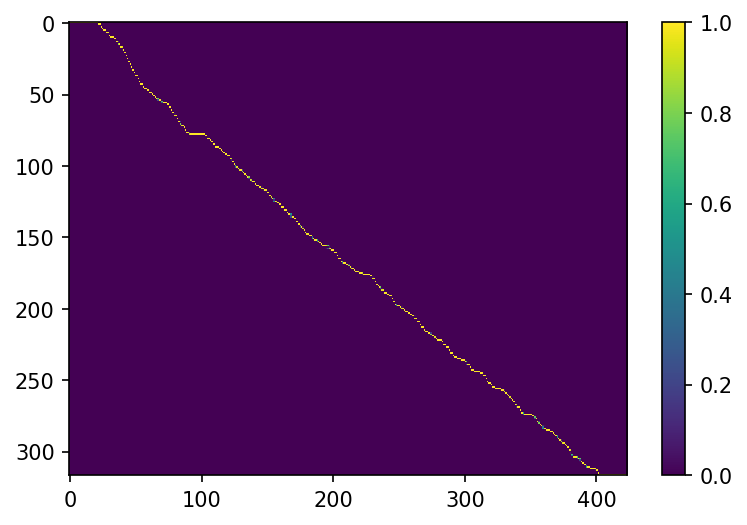

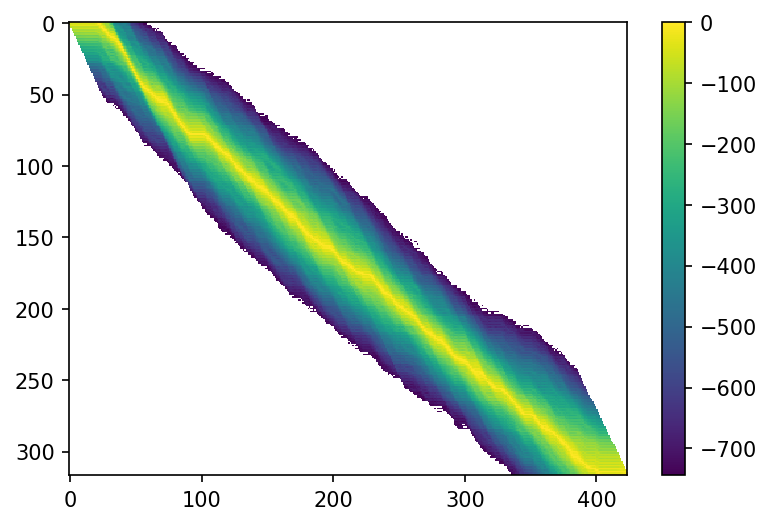

In [66]:
plt.figure(dpi=150)
plt.imshow(align, aspect='auto', interpolation='nearest')
plt.colorbar()

plt.figure(dpi=150)
plt.imshow(np.log(align), aspect='auto', interpolation='nearest')
plt.colorbar()

### Conclusions 🧑‍🎓

* What challenges did you encounter while completing this task?
* What skills have you acquired while doing this task?
* How difficult did you find this task (on a scale from 0 to 10), and why?
* What did you like in this homework, and what didn't?